In [1]:
import numpy as np
import pandas as pd
import bokeh.plotting as bp
from bokeh.layouts import gridplot
#bp.output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Se lee la señal pre-procesada\n",
data_set = pd.read_csv("./data/TrueFX/EUR-USD/datos_procesados_EURUSD-2017-09.csv")

In [3]:
data_set.head()

,date,bid,ask
0,2017-09-01 02:59:30,1.19097,1.19101
1,2017-09-01 02:59:40,1.19099,1.19104
2,2017-09-01 02:59:50,1.19099,1.19104
3,2017-09-01 03:00:00,1.19102,1.19105
4,2017-09-01 03:00:10,1.19101,1.19104


In [4]:
data_set = data_set.set_index(pd.to_datetime(data_set.iloc[:,0])) #se indexan los datos por su fecha y hora
data_set = data_set.drop(['date'],axis=1) #se elimina la columna date

In [5]:
data_set = data_set.drop(data_set['2017-09-17'].index) #elimina un solo registro que quedó volando

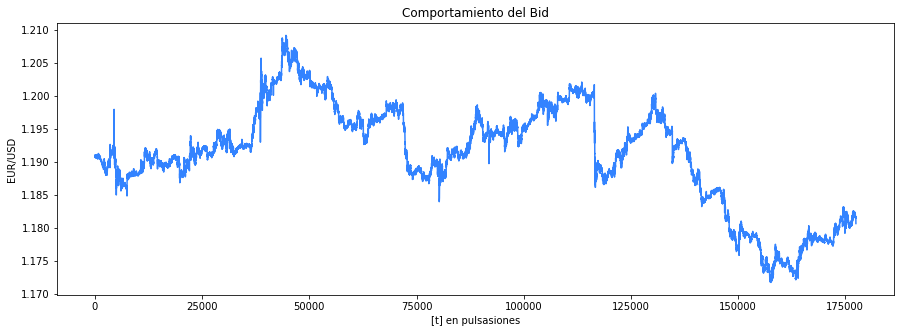

In [6]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del Bid')
plt.xlabel('[t] en pulsasiones')
plt.ylabel('EUR/USD')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,0], alpha=1, color='#3383FF')

In [7]:
print('                   Bussines day - year, month, day')
print()
print(pd.unique(data_set.index.date))

                   Bussines day - year, month, day

[datetime.date(2017, 9, 1) datetime.date(2017, 9, 4)
 datetime.date(2017, 9, 5) datetime.date(2017, 9, 6)
 datetime.date(2017, 9, 7) datetime.date(2017, 9, 8)
 datetime.date(2017, 9, 11) datetime.date(2017, 9, 12)
 datetime.date(2017, 9, 13) datetime.date(2017, 9, 14)
 datetime.date(2017, 9, 15) datetime.date(2017, 9, 18)
 datetime.date(2017, 9, 19) datetime.date(2017, 9, 20)
 datetime.date(2017, 9, 21) datetime.date(2017, 9, 22)
 datetime.date(2017, 9, 25) datetime.date(2017, 9, 26)
 datetime.date(2017, 9, 27) datetime.date(2017, 9, 28)
 datetime.date(2017, 9, 29)]


#### Se crea un validation split
el "v_split" se crea para entrenar y validar el rendimiento del estimador, esa función retorna un generador con los indices de los dias que se tomarán para entrenar y los dias a validar. Los parametros que ella recibe son los siguientes:

   - X, que tiene que ser un dataframe indexado por fechas.
   - n_bdtrain, un entero el cual representa los días que se utilizarán para entrenar.
   - n_bdtest, un entero el cual representa los días que se utilizarán para validar.
   - mday, entero que representa los días que se va corriendo  el estimador para validar.

In [8]:
# Se crea un generador "v_split" para utilizar como método de validación cruzada
def v_split(X, n_bdtrain, n_bdtest, mday):

    """"
    Hace un particionado del dataset, para tomar n_bdtrain días para entrenar
    y n_bdtest para probar, además, mday representa el paso de día a correr.
    X, dataframe, se necesita el indice de este para separar por días.
    n_bdtrain, número de bussines day utilizados para train.
    n_bdtest, número de bussines day utilizados para test.
    mday, días a correr para cada validación.
    
    """
    from datetime import date
    start_day = 0
    
    #Divide el data set según días de train, test y cuanto se va moviendo
    bussines_day = []
    dates = pd.unique(X.index.date) #saco las fechas para luego tomar solo año-mes-día

    for i in dates: bussines_day.append(date.__format__(i,'%Y-%m-%d')) #lista de los bussines day
    
    intervals = []
    count = 0
    for i in bussines_day:
        f = len(X[i])-1 +count
        intervals.append([count,f])
        count = f+1
    
    for i in range(len(intervals)-n_bdtrain):
        yield(np.arange(intervals[start_day:start_day+n_bdtrain][0][0],
                        intervals[start_day:start_day+n_bdtrain][n_bdtrain-1][1]+1),
              np.arange(intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][0][0],
                        intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][n_bdtest-1][1]+1))
    
        start_day += mday
        if start_day+n_bdtest > len(intervals)-n_bdtrain:
            break

In [9]:
print("train data & test data")
print("----------------------")
for i in v_split(data_set,4,1,1):
    print (i)

train data & test data
----------------------
(array([    0,     1,     2, ..., 33080, 33081, 33082]), array([33083, 33084, 33085, ..., 41610, 41611, 41612]))
(array([ 7471,  7472,  7473, ..., 41610, 41611, 41612]), array([41613, 41614, 41615, ..., 50176, 50177, 50178]))
(array([16019, 16020, 16021, ..., 50176, 50177, 50178]), array([50179, 50180, 50181, ..., 58669, 58670, 58671]))
(array([24526, 24527, 24528, ..., 58669, 58670, 58671]), array([58672, 58673, 58674, ..., 66239, 66240, 66241]))
(array([33083, 33084, 33085, ..., 66239, 66240, 66241]), array([66242, 66243, 66244, ..., 74783, 74784, 74785]))
(array([41613, 41614, 41615, ..., 74783, 74784, 74785]), array([74786, 74787, 74788, ..., 83326, 83327, 83328]))
(array([50179, 50180, 50181, ..., 83326, 83327, 83328]), array([83329, 83330, 83331, ..., 91891, 91892, 91893]))
(array([58672, 58673, 58674, ..., 91891, 91892, 91893]), array([ 91894,  91895,  91896, ..., 100434, 100435, 100436]))
(array([ 66242,  66243,  66244, ..., 100434,

#### Se crea una función para construir el dataset ####
Con "build_dataset" lo que se quiere es que mediante la señal, un tamaño de ventana y otros parámetros que explicaré a continuación se genere el dataset como un dataframe indexado por sus fechas. Los parámetros de esta función son:

   - signal, señal a procesar, tiene que ser un dataframe indexado por las fechas.
   - window, tamaño de ventana a coger, este define las columnas del dataset.
   - binary_target, por defecto es False, determina si se quiere el target binario de los datos, esto me permite trabajar con clasificación.
   - delete_constant_values, por defecto es True, dado a que son datos que fluctuan poco, al momento de crear el dataset puede que para el target este se mantenga igual, que el precio no suba ni baje, por ende estos datos los elimino.
   - PNL, por defecto es False, este agrega una columna al dataframe, la cual consiste en anotar la ganancia o perdida según si sube o baja el precio del mercado.

In [10]:
def build_dataset(signal, window, binary_target=False, delete_constant_values=True, PNL=False):
    """
    función para construir un data set
    window: tamaño de la ventana a utilizar para construir el dataset
    signal: dataframe
    binary_target: si desea clasificar, este arroja 2 si el valor se mantiene,
    1 si el valor sube y 0 si este baja.
    delete_constant_values: default: True, elimina los valores que se mantienen
    
    retorna:
    X: dataset, con columna de PNL si así se especifica(default: False)
    y: target
    bt: binary target, default: False
    """
    result = []
    binary = [] #para la columna objetivo binaria
    pnl_col = [] #almacenar el PNL
    indx = signal.index[window+1:] #se toman los indicen que quedarán al final
    for i in range(len(signal) - window-1):
        
        if delete_constant_values == True:
            if signal[i+window] != signal[i+window-1]:

                result.append(signal[i: i + window+1])
                if PNL == True: pnl_col.append(signal[i+window]-signal[i+window-1])
                
                if binary_target == True:
                    if signal[i+window] < signal[i+window-1]: binary.append(0) # 0 si baja
                    if signal[i+window] > signal[i+window-1]: binary.append(1) # 1 si sube
                        
            else: indx = indx.delete(len(result))
        else:

            result.append(signal[i: i + window+1])
            if PNL == True: pnl_col.append(signal[i+window]-signal[i+window-1])
            
        if binary_target == True and delete_constant_values == False:
            if signal[i+window] == signal[i+window-1]: binary.append(2) # 2 si se mantiene
            if signal[i+window] < signal[i+window-1]: binary.append(0) # 1 si baja
            if signal[i+window] > signal[i+window-1]: binary.append(1) # 0 si sube
    
    data = pd.DataFrame(np.array(result), index=indx)
    y = np.array(data.iloc[:,window])
    data = data.drop(window,axis=1)
    if PNL == True: data['PNL'] = pnl_col
    if binary_target == True: return data, y, np.array(binary)
    else: return data, y

In [11]:
data_set.head()

,bid,ask
date,,
2017-09-01 02:59:30,1.19097,1.19101
2017-09-01 02:59:40,1.19099,1.19104
2017-09-01 02:59:50,1.19099,1.19104
2017-09-01 03:00:00,1.19102,1.19105
2017-09-01 03:00:10,1.19101,1.19104


#### Construyendo el dataset
se prueba construyendo el dataset con una ventana de tamaño 3 ya que con esta es que se obtuvo mejores resultados.

In [12]:
window = 3
X, y_reg, bt = build_dataset(data_set.iloc[:,0], window, binary_target=True, delete_constant_values=True, PNL=True)

In [13]:
X.shape, bt.shape, y_reg.shape

((151524, 4), (151524,), (151524,))

In [14]:
X.head()

,0,1,2,PNL
date,,,,
2017-09-01 03:00:10,1.19097,1.19099,1.19099,0.00003
2017-09-01 03:00:20,1.19099,1.19099,1.19102,-0.00001
2017-09-01 03:00:30,1.19099,1.19102,1.19101,-0.00005
2017-09-01 03:00:40,1.19102,1.19101,1.19096,0.00001
2017-09-01 03:00:50,1.19101,1.19096,1.19097,0.00003


In [15]:
print(y_reg[:5])
print(bt[:5])

[ 1.19102  1.19101  1.19096  1.19097  1.191  ]
[1 0 0 1 1]


Se utiliza cross_val_score pasandole el parámetro cv para la partición del dataset a la hora de entrenar y probrar, se utiliza la función score que este trae por defecto

In [16]:
from sklearn.model_selection import cross_val_score

y = bt

from sklearn.neighbors import KNeighborsClassifier

n_bdtrain = 4 #número de dias con los que se entrena
n_bdtest = 1  #número de días con los que se hace el test
move_day = 1  #número de días que se van corriendo

vs = v_split(X,n_bdtrain,n_bdtest,move_day)
k = KNeighborsClassifier()

for train_index, test_index in vs:
    print ('train = ',train_index, 'test = ',test_index)
print()
result = cross_val_score(k, X, y, cv=v_split(X, n_bdtrain, n_bdtest, move_day))

print(result)
print()
print('score avg = ', np.mean(result))
print('score std = ', np.std(result))

train =  [    0     1     2 ..., 27897 27898 27899] test =  [27900 27901 27902 ..., 35207 35208 35209]
train =  [ 6332  6333  6334 ..., 35207 35208 35209] test =  [35210 35211 35212 ..., 42730 42731 42732]
train =  [13401 13402 13403 ..., 42730 42731 42732] test =  [42733 42734 42735 ..., 49994 49995 49996]
train =  [20690 20691 20692 ..., 49994 49995 49996] test =  [49997 49998 49999 ..., 56441 56442 56443]
train =  [27900 27901 27902 ..., 56441 56442 56443] test =  [56444 56445 56446 ..., 63613 63614 63615]
train =  [35210 35211 35212 ..., 63613 63614 63615] test =  [63616 63617 63618 ..., 70881 70882 70883]
train =  [42733 42734 42735 ..., 70881 70882 70883] test =  [70884 70885 70886 ..., 78258 78259 78260]
train =  [49997 49998 49999 ..., 78258 78259 78260] test =  [78261 78262 78263 ..., 85601 85602 85603]
train =  [56444 56445 56446 ..., 85601 85602 85603] test =  [85604 85605 85606 ..., 92993 92994 92995]
train =  [63616 63617 63618 ..., 92993 92994 92995] test =  [ 92996  9299

se crea la clase PNLEstimatorWrapper para crear nuestra propia función score y así retornar nuestros diferentes tipos de score

In [17]:
class PNLEstimatorWrapper:
    
    def __init__(self, estimator, PNL_column, exclude_PNL_column_from_training=True):
        self.estimator = estimator
        self.PNL_column = PNL_column
        self.exclude_PNL_column_from_training = exclude_PNL_column_from_training
        
    def fit(self, X, y):
        assert self.PNL_column in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column]]
        self.estimator.fit(X,y)
        
    def predict(self, X):
        assert self.PNL_column in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column]]
        return self.estimator.predict(X)
    
    def score(self, X, y):
        PNL = X[self.PNL_column]
        pre = self.predict(X)
        r = sum((y==pre)*abs(PNL) - (y!=pre)*abs(PNL))
        sell = sum((pre==0)*1)
        buy = sum((pre==1)*1)
        
        count_ones, count_zeros = 0,0
        l_one, l_zero = [],[]
        for i in pre:
            if i==1:
                l_zero.append(count_zeros)
                count_zeros = 0
                count_ones += 1
            else:
                l_one.append(count_ones)
                count_zeros += 1
                count_ones = 0
        l_zero.append(count_zeros)
        l_one.append(count_ones)
        
        #return np.array([r,buy,sell,max(l_one),max(l_zero)])
        return np.array([r,buy,sell,max(l_one),max(l_zero)]), pre
        
    def get_params(self, deep=False):
        return {"PNL_column": self.PNL_column,
                "exclude_PNL_column_from_training": self.exclude_PNL_column_from_training,
                "estimator": self.estimator}

#### creando la función step_validation
esta función me recibe el estimador en el cual va implicita la clase PNLEstimatorWrapper, lo que hace es coger el generador "v_split" para aplicarlo con el estimador y así validar los datos.


In [18]:
def step_validation(estimator, X, y, cv):
    '''
    Recibe el estimador,X,y, y un generador cv con el cual hace la validación
    dependiendo que la configuración que este tenga
    '''
    result = []
    for index in cv:
        estimator.fit(X.iloc[index[0]], y[index[0]])
        result.append(estimator.score(X.iloc[index[1]], y[index[1]]))
    return np.array(result)

Debido a que la función score arroja un vector que en cada posición tiene un vector con datos del PNL y otro con las predicciones, se hace necesario crear una función llamada "redim" para tratar esta salida y poder separar los datos del PNL y los del predict.

In [19]:
def redim(signal):
    '''
    recibe un array plano el cual convierte en dos salidas,
    en una de estas se encuentran los resultados pertinentes
    a medir con el PNL y en el otro las predicciones.
    '''
    result = signal[:,0][0]
    predict = np.array(signal[:,1][0],dtype=np.float16)
    for i in range(1,len(signal)):
        result = np.concatenate((result,signal[:,0][i]))
        predict = np.concatenate((predict,signal[:,1][i]))
    result = result.reshape((len(signal),signal[:,0][0].shape[0]))
    return result, predict

Se prueba con un GaussianNB para ver su rendimiento, esto teniendo cuenta que solo es con un mes de datos

In [20]:
from sklearn.naive_bayes import GaussianNB
    
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column='PNL')
result_GNB = step_validation(est_GNB, X, y, v_split(X,4,1,1))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- GaussianNB ----------------
average PNL :  0.000563529411764
average buy:  3376.23529412
average sell:  3895.76470588
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0  -0.01038     0.0  7310.0           0.0         7310.0
1   0.00152  7523.0     0.0        7523.0            0.0
2   0.00835     0.0  7264.0           0.0         7264.0
3  -0.00147     0.0  6447.0           0.0         6447.0
4  -0.00230  2133.0  5039.0        2128.0         5037.0
5   0.00323  7268.0     0.0        7268.0            0.0
6   0.00426  3811.0  3566.0        3566.0         2617.0
7   0.00088    21.0  7322.0          13.0         4264.0
8  -0.00425     0.0  7392.0           0.0         7392.0
9   0.00475   898.0  6394.0         898.0         6394.0
10  0.00660  7248.0   190.0        5869.0          157.0
11  0.00297   153.0  7187.0          53.0         5807.0
12  0.00197  6482.0   690.0        4816.0          440.0
13 -0.00545  7293.0     0.0        7

### Se pintarán las ventas en color rojo y las compras en color verde!

para poder graficar la señal original con las predicciones, hay que tener en cuenta que los primeros 4 días que se eligieron anteriormente en la variable "n_bdtrain" se deben omitir.

In [21]:
firts_4bd = 27900 #primeros 4 días

el vector de predicción tiene el mismo tamaño que el vector de target, teniendo en cuenta que este empieza después de los 4 días que tenemos para entrenar desde un principio

In [22]:
len(predict_GNB),len(y)- firts_4bd

(123624, 123624)

In [23]:
buy_GNB = (predict_GNB==1)*y_reg[firts_4bd:] #para graficar las compras sobre la señal original
buy_GNB[buy_GNB==0] = np.nan 
print (buy_GNB.shape)

sell_GNB = (predict_GNB==0)*y_reg[firts_4bd:] #para graficar las ventas sobre la señal original
sell_GNB[sell_GNB==0] = np.nan
print (sell_GNB.shape)

(123624,)
(123624,)


In [24]:
dates = np.unique(data_set.index.date) #para graficas el numero de ventas y comprar por dia
x_axis = X.index[firts_4bd:] #para graficar los resultados por datetime

In [25]:
x_axis.shape, sell_GNB.shape

((123624,), (123624,))

In [26]:
x_axis

DatetimeIndex(['2017-09-07 00:01:00', '2017-09-07 00:01:10',
               '2017-09-07 00:01:20', '2017-09-07 00:01:30',
               '2017-09-07 00:01:40', '2017-09-07 00:01:50',
               '2017-09-07 00:02:20', '2017-09-07 00:02:50',
               '2017-09-07 00:03:00', '2017-09-07 00:03:10',
               ...
               '2017-09-29 23:57:10', '2017-09-29 23:57:20',
               '2017-09-29 23:57:30', '2017-09-29 23:58:00',
               '2017-09-29 23:58:20', '2017-09-29 23:58:30',
               '2017-09-29 23:58:40', '2017-09-29 23:58:50',
               '2017-09-29 23:59:00', '2017-09-29 23:59:20'],
              dtype='datetime64[ns]', name='date', length=123624, freq=None)

In [27]:
p1_GNB = bp.figure(width=800, height=300,title='buys and sells with a GaussianNB',x_axis_type='datetime',
               title_location = 'above')
p1_GNB.triangle(x_axis, buy_GNB, color='green', legend='buys')
p1_GNB.xaxis.axis_label = 'Datetime'
p1_GNB.yaxis.axis_label = 'EUR/USD'
p1_GNB.triangle(x_axis, sell_GNB, color='red', angle=45, legend='sells')
p1_GNB.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2_GNB = bp.figure(width=400, height=200, title='buys per day', x_axis_type='datetime')
p2_GNB.line(dates[n_bdtrain:], result_GNB[:,1], color='green')

p3_GNB = bp.figure(width=400, height=200, title='sells per day', x_axis_type='datetime')
p3_GNB.line(dates[n_bdtrain:], result_GNB[:,2], color='red')

bp.show(gridplot([[p1_GNB],[p2_GNB,p3_GNB]], toolbar_location="right"))
bp.output_file(filename='grafico GaussianNB.html', title='GaussianNB')
bp.reset_output()
#bp.save(bp.curdoc(), filename='grafico GaussianNB.html', title='GaussianNB')

In [47]:
bp.output_file?

se gráfica el PNL y su media para poder ver graficamente las veces que se gana o se pierde y si en general se termina ganando o perdiendo dinero

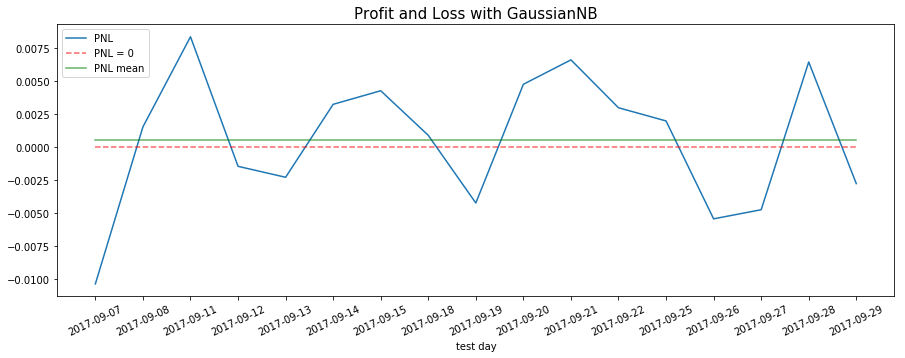

In [29]:
plt.figure(figsize=(15,5))
    
plt.title('Profit and Loss with GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,0])), result_GNB[:,0], label='PNL')
plt.plot(range(len(result_GNB[:,0])), np.zeros(len(result_GNB[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_GNB[:,0])), np.ones(len(result_GNB[:,0]))*np.mean(result_GNB[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

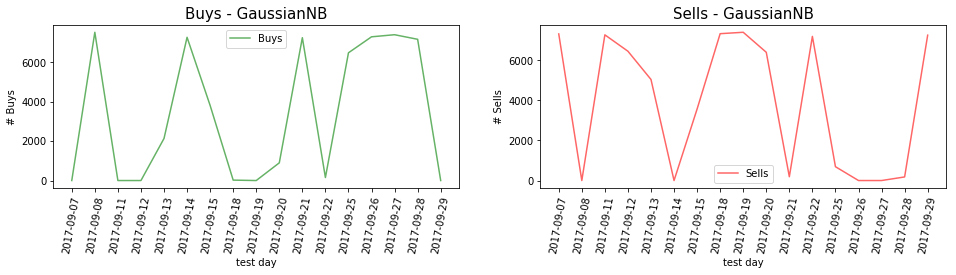

In [30]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buys - GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,1])), result_GNB[:,1],color='green', alpha=0.6, label='Buys')
plt.xlabel('test day')
plt.ylabel('# Buys')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();
    
plt.subplot(1,2,2)
plt.title('Sells - GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,2])), result_GNB[:,2],color='red', alpha=0.6, label='Sells')
plt.xlabel('test day')
plt.ylabel('# Sells')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

Se prueba con un KNeighborsClassifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column='PNL')
result_KNC = step_validation(est_KNC, X, y, v_split(X,4,1,1))
result_KNC, predict_KNC = redim(result_KNC)
print('-------- KNeighborsClassifier -------')
print('average PNL: ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

-------- KNeighborsClassifier -------
average PNL:  0.000774117647058
average buy:  3653.58823529
average sell:  3618.41176471
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0   0.00180  1463.0  5847.0          10.0         2742.0
1  -0.01208  4478.0  3045.0         319.0           76.0
2  -0.00349  3338.0  3926.0          61.0           60.0
3   0.00069  3081.0  3366.0          14.0           19.0
4  -0.00092  4387.0  2785.0        1783.0           17.0
5   0.01233  3856.0  3412.0          96.0           33.0
6  -0.01360  3688.0  3689.0          32.0           53.0
7   0.00354  3497.0  3846.0          20.0           24.0
8  -0.00211  2687.0  4705.0          15.0          747.0
9   0.00541  2006.0  5286.0          14.0         1330.0
10  0.00572  4600.0  2838.0         313.0           15.0
11  0.00055  3625.0  3715.0          14.0           14.0
12  0.00273  2881.0  4291.0          51.0          994.0
13 -0.00079  5612.0  1681.0        42

#### Pintando con bokeh, se guarda la imagen debido a que consume una cantidad de memoria RAM considerable

In [32]:
#si las predicciones son iguales a uno, esto quiere decir que subirá el precio en el mercado,
#por ende tengo que comprar
buy_KNC = (predict_KNC==1)*y_reg[firts_4bd:]
buy_KNC[buy_KNC==0] = np.nan
print (buy_KNC.shape)

sell_KNC = (predict_KNC==0)*y_reg[firts_4bd:]
sell_KNC[sell_KNC==0] = np.nan
print (sell_KNC.shape)

(123624,)
(123624,)


In [33]:
p1_KNC = bp.figure(width=800, height=300,title='buys and sells with a KNeighborsClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_KNC.triangle(x_axis, buy_KNC, color='green', legend='buys')
p1_KNC.xaxis.axis_label = 'Datetime'
p1_KNC.yaxis.axis_label = 'EUR/USD'
p1_KNC.triangle(x_axis, sell_KNC, color='red', angle=45, legend='sells')
p1_KNC.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2_KNC = bp.figure(width=400, height=200, title='buys per day', x_axis_type='datetime')
p2_KNC.line(dates[n_bdtrain:], result_KNC[:,1], color='green')

p3_KNC = bp.figure(width=400, height=200, title='sells per day', x_axis_type='datetime')
p3_KNC.line(dates[n_bdtrain:], result_KNC[:,2], color='red')

bp.show(gridplot([[p1_KNC],[p2_KNC,p3_KNC]], toolbar_location="right"))
bp.output_file(filename='grafico KNeihgborsClassifier.html', title='KNeihgborsClassifier')
#bp.save(bp.curdoc(), filename='grafico KNeihgborsClassifier.html', title='KNeihgborsClassifier')
bp.reset_output()

se gráfica el PNL y su media para poder ver graficamente las veces que se gana o se pierde y si en general se termina ganando o perdiendo dinero

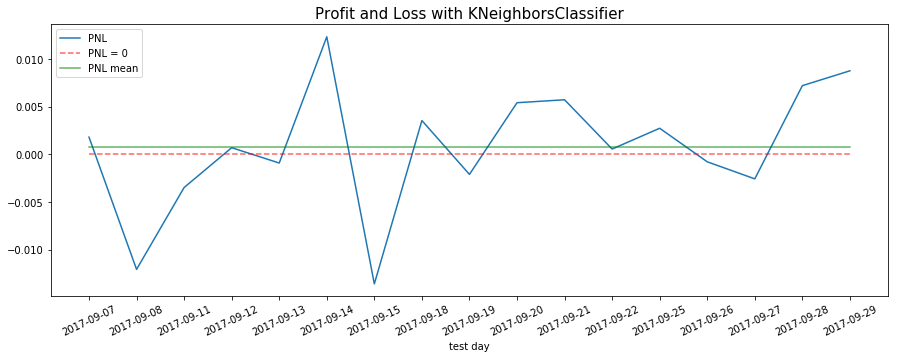

In [34]:
plt.figure(figsize=(15,5))
    
plt.title('Profit and Loss with KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,0])), result_KNC[:,0], label='PNL')
plt.plot(range(len(result_KNC[:,0])), np.zeros(len(result_KNC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_KNC[:,0])), np.ones(len(result_KNC[:,0]))*np.mean(result_KNC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

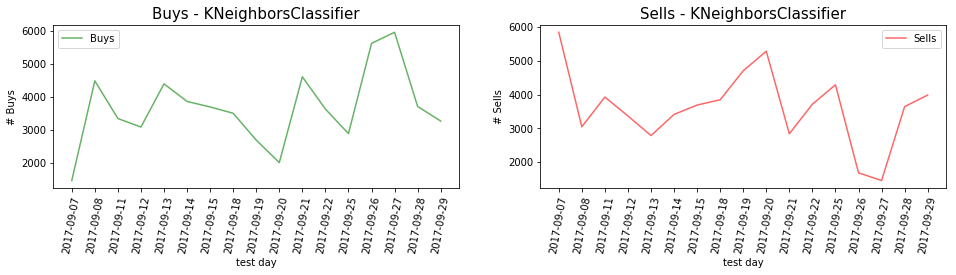

In [35]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buys - KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,1])), result_KNC[:,1],color='green', alpha=0.6, label='Buys')
plt.xlabel('test day')
plt.ylabel('# Buys')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sells - KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,2])), result_KNC[:,2],color='red', alpha=0.6, label='Sells')
plt.xlabel('test day')
plt.ylabel('# Sells')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

se prueba con un DecisionTreeClassifier

In [36]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result_DTC = step_validation(est_DTC, X, y, v_split(X,4,1,1))
result_DTC, predict_DTC = redim(result_DTC)
print('------ DecisionTreeClassifier -------')
print('average PNL: ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

------ DecisionTreeClassifier -------
average PNL:  0.00152470588235
average buy:  3675.58823529
average sell:  3596.41176471
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0   0.00730  1674.0  5636.0          20.0         2738.0
1  -0.00472  5173.0  2350.0        1284.0           57.0
2  -0.00713  3493.0  3771.0          18.0           38.0
3  -0.00455  3077.0  3370.0          14.0           22.0
4   0.00028  4448.0  2724.0        1759.0           14.0
5   0.00155  3736.0  3532.0          88.0           32.0
6  -0.00402  3325.0  4052.0          18.0           35.0
7   0.01256  3462.0  3881.0          13.0           24.0
8   0.01211  2886.0  4506.0          14.0          364.0
9   0.00559  2174.0  5118.0          13.0         1332.0
10 -0.00502  3904.0  3534.0          33.0           35.0
11 -0.00269  3518.0  3822.0          15.0           11.0
12  0.01511  2806.0  4366.0          49.0         1699.0
13 -0.00553  5891.0  1402.0        420

In [37]:
#si las predicciones son iguales a uno, esto quiere decir que subirá el precio en el mercado,
#por ende tengo que comprar
buy_DTC = (predict_DTC==1)*y_reg[firts_4bd:]
buy_DTC[buy_DTC==0] = np.nan
print (buy_DTC.shape)

sell_DTC = (predict_DTC==0)*y_reg[firts_4bd:]
sell_DTC[sell_DTC==0] = np.nan
print (sell_DTC.shape)

(123624,)
(123624,)


se guarda el gráfico de bokeh debido que si se pinta en el jupyter se va consumiendo mucha memoria ram

In [38]:
p1 = bp.figure(width=800, height=300,title='buys and sells with a DecisionTreeClassifier',x_axis_type='datetime',
               title_location = 'above')
p1.triangle(x_axis, buy_DTC, color='green', legend='buys')
p1.xaxis.axis_label = 'Datetime'
p1.yaxis.axis_label = 'EUR/USD'
p1.triangle(x_axis, sell_DTC, color='red', angle=45, legend='sells')
p1.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2 = bp.figure(width=400, height=200, title='buys per day', x_axis_type='datetime')
p2.line(dates[n_bdtrain:], result_DTC[:,1], color='green')

p3 = bp.figure(width=400, height=200, title='sells per day', x_axis_type='datetime')
p3.line(dates[n_bdtrain:], result_DTC[:,2], color='red')
    
bp.show(gridplot([[p1],[p2,p3]], toolbar_location="right"))
bp.output_file(filename='grafico DecisionTreeClassifier.html')
bp.reset_output()

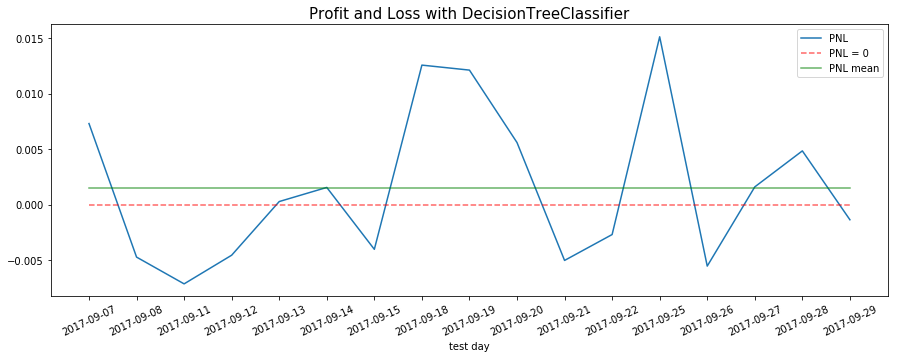

In [39]:
plt.figure(figsize=(15,5))

plt.title('Profit and Loss with DecisionTreeClassifier', size=15)
plt.plot(range(len(result_DTC[:,0])), result_DTC[:,0], label='PNL')
plt.plot(range(len(result_DTC[:,0])), np.zeros(len(result_DTC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_DTC[:,0])), np.ones(len(result_DTC[:,0]))*np.mean(result_DTC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

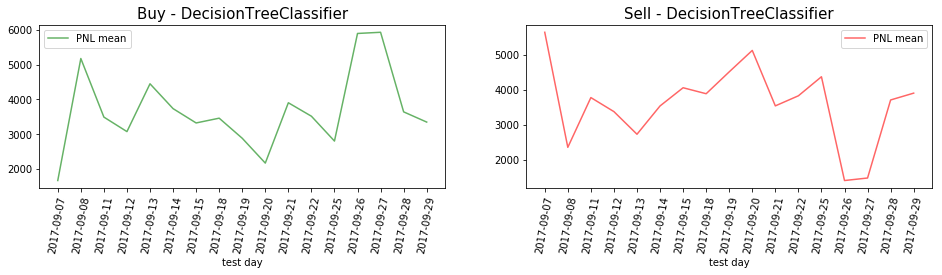

In [40]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buy - DecisionTreeClassifier', size=15),
plt.plot(range(len(result_DTC[:,1])), result_DTC[:,1],color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sell - DecisionTreeClassifier', size=15)
plt.plot(range(len(result_DTC[:,2])), result_DTC[:,2],color='red', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

probando con un RandomForestClassifier, con ciertos parametros establecidos los cuales me han arrojado mejores resultados

In [41]:
from sklearn.ensemble import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('RandomForestClassifier')
print('PNL promedio: ', np.mean(result_RFC[:,0]))
print('buy promedio: ', np.mean(result_RFC[:,1]))
print('sell promedio: ', np.mean(result_RFC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

RandomForestClassifier
PNL promedio:  0.00238588235294
buy promedio:  3679.76470588
sell promedio:  3592.23529412
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0  -0.00332  1684.0  5626.0          18.0         2738.0
1  -0.00390  4745.0  2778.0        1278.0           58.0
2  -0.00421  3395.0  3869.0          38.0           56.0
3   0.00005  3087.0  3360.0          13.0           20.0
4  -0.00146  4391.0  2781.0        1761.0           15.0
5   0.00509  3860.0  3408.0          91.0           27.0
6  -0.01198  3637.0  3740.0          32.0           49.0
7   0.02680  3571.0  3772.0          19.0           26.0
8   0.00295  2696.0  4696.0          11.0          365.0
9   0.00141  2100.0  5192.0          15.0         1334.0
10  0.00576  4389.0  3049.0          69.0           26.0
11 -0.00013  3547.0  3793.0          16.0           13.0
12  0.00129  2834.0  4338.0          48.0         1698.0
13 -0.00461  5791.0  1502.0        4227.0         

In [42]:
#si las predicciones son iguales a uno, esto quiere decir que subirá el precio en el mercado,
#por ende tengo que comprar
buy_RFC = (predict_RFC==1)*y_reg[firts_4bd:]
buy_RFC[buy_RFC==0] = np.nan
print (buy_RFC.shape)

#si las predicciones son iguales a cero, esto quiere decir que bajará el precio en el mercado,
#por ende tengo que vender
sell_RFC = (predict_RFC==0)*y_reg[firts_4bd:]
sell_RFC[sell_RFC==0] = np.nan
print (sell_RFC.shape)

(123624,)
(123624,)


In [43]:
p1 = bp.figure(width=800, height=300,title='buys and sells with a RandomForestClassifier',x_axis_type='datetime',
               title_location = 'above')
p1.triangle(x_axis, buy_RFC, color='green', legend='buys')
p1.xaxis.axis_label = 'Datetime'
p1.yaxis.axis_label = 'EUR/USD'
p1.triangle(x_axis, sell_RFC, color='red', angle=45, legend='sells')
p1.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2 = bp.figure(width=400, height=200, title='buys per day', x_axis_type='datetime')
p2.line(dates[n_bdtrain:], result_RFC[:,1], color='green')

p3 = bp.figure(width=400, height=200, title='sells per day', x_axis_type='datetime')
p3.line(dates[n_bdtrain:], result_RFC[:,2], color='red')
    
bp.show(gridplot([[p1],[p2,p3]], toolbar_location="right"))
#bp.output_file(filename='grafico RandomForestClassifier.html')

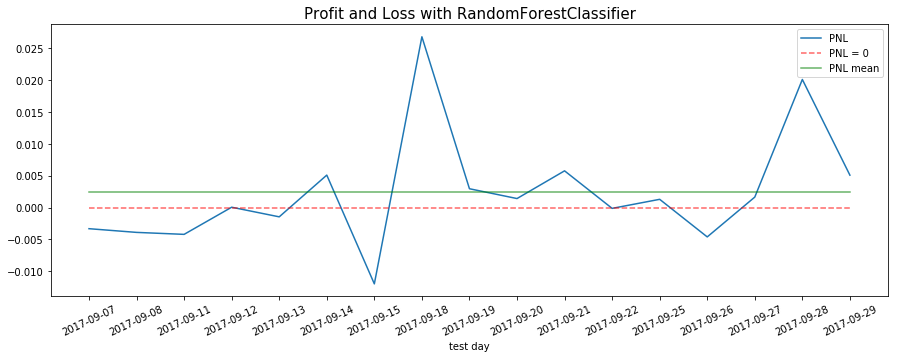

In [44]:
plt.figure(figsize=(15,5))

plt.title('Profit and Loss with RandomForestClassifier', size=15)
plt.plot(range(len(result_RFC[:,0])), result_RFC[:,0], label='PNL')
plt.plot(range(len(result_RFC[:,0])), np.zeros(len(result_RFC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_RFC[:,0])), np.ones(len(result_RFC[:,0]))*np.mean(result_RFC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

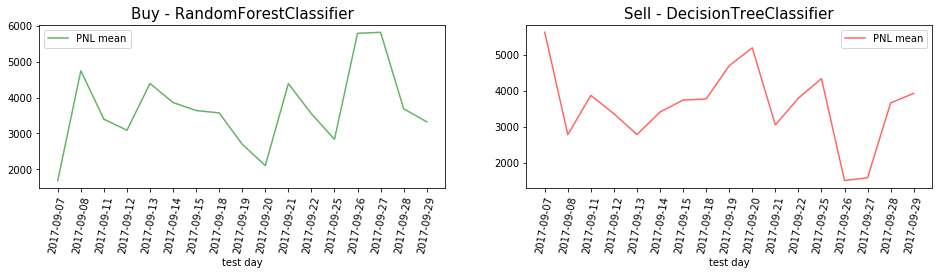

In [45]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buy - RandomForestClassifier', size=15)
plt.plot(range(len(result_RFC[:,1])), result_RFC[:,1],color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sell - DecisionTreeClassifier', size=15)
plt.plot(range(len(result_RFC[:,2])), result_RFC[:,2],color='red', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();